## imdb dataset

In [1]:
%matplotlib inline
import collections
import re
import os
import nltk
import random
import matplotlib
import matplotlib.pyplot as plt

def get_sent_in_directory(path_directory):
    sents = []
    for filename in os.listdir(path_directory):
        if os.path.isfile(os.path.join(path_directory, filename)):
            with open(os.path.join(path_directory, filename), 'r') as f:
                for line in f:
                    sents.append(nltk.tokenize.word_tokenize(line))
    return sents
                    
                
train_pos = get_sent_in_directory("./aclImdb/train/pos")
train_neg = get_sent_in_directory("./aclImdb/train/neg")
test_pos = get_sent_in_directory("./aclImdb/test/pos")
test_neg = get_sent_in_directory("./aclImdb/test/neg")

print("len(train_pos)", len(train_pos))
print("len(train_neg)", len(train_neg))
print("len(test_pos)", len(test_pos))
print("len(test_neg)", len(test_neg))
print("train_pos[0]", train_pos[0])

len(train_pos) 12500
len(train_neg) 12500
len(test_pos) 12500
len(test_neg) 12500
train_pos[0] ['``', 'The', 'Last', 'Hard', 'Men', "''", 'is', 'a', 'typical', 'western', 'for', 'the', '70', "'s", '.', 'Most', 'of', 'them', 'seem', 'to', 'be', 'inspired', 'by', 'Sam', 'Peckinpah', '.', 'Also', 'this', 'one', ',', 'but', 'Director', 'Andrew', 'McLaglan', 'is', 'a', 'John', 'Ford', 'Pupil', 'and', 'this', 'can', 'be', 'obviously', 'shown', 'in', 'many', 'scenes', '.', 'IMO', 'the', 'beginning', 'is', 'very', 'good', '.', 'In', 'a', 'certain', 'way', 'McLaglan', 'wanted', 'to', 'show', 'the', 'audience', 'a', 'travel', 'from', 'the', 'civilization', 'to', 'the', 'wilderness', '.', 'In', 'the', 'third', 'part', 'there', 'are', 'some', 'illogical', 'flaws', 'and', 'I', 'complain', 'a', 'bit', 'about', 'Charlton', 'Heston', '.', 'He', 'has', 'to', 'play', 'an', 'old', 'ex-lawman', 'named', 'Sam', 'Burgade', 'but', 'he', 'is', 'in', 'a', 'fantastic', 'physical', 'shape', '.', 'I', 'never', 'g

unique word: 165718
# of sents: 25000
max len(sents[i]): 2502


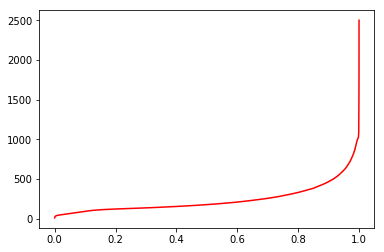

In [2]:
corpus_counter = collections.Counter()
train_preprocess = []
test_preprocess = []
for sent in train_pos:
    res = []
    for word in sent:
        if re.search('[a-zA-Z]', word):
            corpus_counter[word.lower()] += 1
            res.append(word.lower())
    train_preprocess.append((res, 1))
for sent in train_neg:
    res = []
    for word in sent:
        if re.search('[a-zA-Z]', word):
            corpus_counter[word.lower()] += 1
            res.append(word.lower())
    train_preprocess.append((res, 0))
for sent in test_pos:
    res = []
    for word in sent:
        if re.search('[a-zA-Z]', word):
            corpus_counter[word.lower()] += 1
            res.append(word.lower())
    test_preprocess.append((res, 1))
for sent in test_neg:
    res = []
    for word in sent:
        if re.search('[a-zA-Z]', word):
            corpus_counter[word.lower()] += 1
            res.append(word.lower())
    test_preprocess.append((res, 0))


print("unique word:", len(corpus_counter))
print("# of sents:", len(train_preprocess))
print("max len(sents[i]):", max([len(s) for s, _ in train_preprocess]))

train_length = []
for sent, label in train_preprocess:
    train_length.append(len(sent))
train_length = sorted(train_length)
stat_x, stat_y = [], []
for i, l in enumerate(train_length):
    stat_x.append(i / len(train_length))
    stat_y.append(l)
plt.plot(stat_x, stat_y, 'r-')
plt.show()

In [3]:
import tensorflow as tf
import numpy as np


class Classifier:
    def __init__(self, n_input, labels):
        self.labels = labels
        self.n_input = n_input
        
        ######################
        # Graph Construction #
        ######################
        self.graph = tf.Graph()
        with self.graph.as_default():               
            self.sent_embedding = tf.placeholder(tf.float32, shape=(None, self.n_input), name="sent_embedding")
            self.clf_label = tf.placeholder(tf.int32, shape=(None,), name="label")
                        
            # classifier layer
            with tf.variable_scope("classifier") as scope:
                clf_dense = tf.layers.dense(self.sent_embedding, 30, activation=tf.nn.relu)
                self.clf_output = tf.layers.dense(clf_dense, len(self.labels))
                   
            # construct classifier loss
            self.loss = tf.reduce_sum(
                tf.nn.sparse_softmax_cross_entropy_with_logits(
                    labels=self.clf_label,
                    logits=self.clf_output,
                )
            )        
            
            # Calculate and clip gradients
            params = tf.trainable_variables()
            gradients = tf.gradients(self.loss, params)
            self.clipped_gradients, _ = tf.clip_by_global_norm(gradients, 1)
            # Optimization
            optimizer = tf.train.AdamOptimizer()
            self.op_train = optimizer.apply_gradients(zip(self.clipped_gradients, params))
               
            # initializer
            gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.1)
            self.sess = tf.Session(
                graph=self.graph,
                config=tf.ConfigProto(gpu_options=gpu_options)
            )           
            self.init = tf.global_variables_initializer()
            self.sess.run(self.init)
    
    def train(self, batch_sent_embedding, batch_labels):
        _, loss, pred = self.sess.run(
            [self.op_train, self.loss, self.clf_output],
            feed_dict={
                self.sent_embedding: batch_sent_embedding,
                self.clf_label: batch_labels
            }
        )
        return loss, pred
    
    def predict(self, batch_sent_embedding):
        pred = self.sess.run(
            self.clf_output,
            feed_dict={
                self.sent_embedding: batch_sent_embedding
            }
        )
        return pred

def clf_evaluate(batch_pred, batch_labels):
    assert batch_pred.shape[0] == batch_labels.shape[0]
    hit, tot = 0, 0
    for i in range(batch_labels.shape[0]):
        if np.argmax(batch_pred[i]) == batch_labels[i]:
            hit += 1
        tot += 1
    return 1. * hit / tot

In [4]:
def generate_data(sents, labels, origin_vocabulary):
    assert len(sents) == len(labels)
    n = len(sents)
    batch_sents = np.zeros((n, len(origin_vocabulary)), dtype=np.float32)
    batch_labels = np.zeros((n,), dtype=np.int32)
    for i in range(n):
        for w in sents[i]:
            if w in origin_vocabulary:
                batch_sents[i][origin_vocabulary[w]] += 1
        batch_labels[i] = labels[i]
    return batch_sents, batch_labels

def clf_get_total_accuracy(sents, labels, clf, origin_vocabulary):
    cur_idx = 0
    hit, tot = 0, 0
    while cur_idx < len(sents):
        batch_sents, batch_labels = generate_data(
            sents[cur_idx:cur_idx+n_batch_size], labels[cur_idx:cur_idx+n_batch_size], origin_vocabulary)
        batch_preds = clf.predict(batch_sents)
        assert batch_preds.shape[0] == batch_labels.shape[0]
        cur_acc = clf_evaluate(batch_preds, batch_labels)
        hit += cur_acc * batch_preds.shape[0]
        tot += batch_preds.shape[0]
        cur_idx += n_batch_size
    return 1. * hit / tot


vocabulary_size = 2048
origin_vocabulary = {}
for word, n in corpus_counter.most_common(vocabulary_size):
    origin_vocabulary["{}".format(word)] = len(origin_vocabulary)
labels = {"0": 0, "1": 1}
clf = Classifier(len(origin_vocabulary), labels)

n_batch_size=100

# generate training/testing data
preprocess_sents = []
preprocess_labels = []
random.shuffle(train_preprocess)
for sent, label in train_preprocess:
    preprocess_sents.append(sent)
    preprocess_labels.append(label)
n_train = int(len(preprocess_sents) * 0.8)
n_valid = len(preprocess_sents) - n_train

print("n_train", n_train, "n_valid", n_valid)
train_sents = preprocess_sents[:n_train]
train_labels = preprocess_labels[:n_train]
valid_sents = preprocess_sents[n_train:]
valid_labels = preprocess_labels[n_train:]
test_sents, test_labels = [], []
for sent, label in test_preprocess:
    test_sents.append(sent)
    test_labels.append(label)

best_epoch = None
best_valid_acc = None
early_stopping = 20

for epoch in range(100):
    cur_idx = 0
    while cur_idx < n_train:
        batch_sents, batch_labels = generate_data(
            train_sents[cur_idx:cur_idx+n_batch_size], train_labels[cur_idx:cur_idx+n_batch_size], origin_vocabulary)
        loss, pred = clf.train(batch_sents, batch_labels)
        cur_idx += n_batch_size
    print("last loss", loss)
    train_acc = clf_get_total_accuracy(
        train_sents, train_labels, clf, origin_vocabulary
    )
    print("epoch", epoch, "train", train_acc) 
    valid_acc = clf_get_total_accuracy(
        valid_sents, valid_labels, clf, origin_vocabulary
    )
    print("epoch", epoch, "valid", valid_acc) 
    test_acc = clf_get_total_accuracy(
        test_sents, test_labels, clf, origin_vocabulary
    )
    print("epoch", epoch, "test", test_acc) 
    if best_valid_acc is None or best_valid_acc < valid_acc:
        best_valid_acc = valid_acc
        best_epoch = epoch
    print("best_epoch (valid)", best_epoch)
    if epoch - best_epoch == early_stopping:
        break

n_train 20000 n_valid 5000
last loss 31.1001
epoch 0 train 0.8913
epoch 0 valid 0.862
epoch 0 test 0.86536
best_epoch (valid) 0
last loss 30.9643
epoch 1 train 0.90115
epoch 1 valid 0.8632
epoch 1 test 0.865
best_epoch (valid) 1
last loss 28.6386
epoch 2 train 0.90855
epoch 2 valid 0.8604
epoch 2 test 0.8632
best_epoch (valid) 1
last loss 25.5859
epoch 3 train 0.9163
epoch 3 valid 0.86
epoch 3 test 0.8618
best_epoch (valid) 1
last loss 22.093
epoch 4 train 0.9208
epoch 4 valid 0.8578
epoch 4 test 0.85892
best_epoch (valid) 1
last loss 25.338
epoch 5 train 0.91025
epoch 5 valid 0.852
epoch 5 test 0.8512
best_epoch (valid) 1
last loss 27.1964
epoch 6 train 0.91845
epoch 6 valid 0.8528
epoch 6 test 0.85072
best_epoch (valid) 1
last loss 23.0595
epoch 7 train 0.9207
epoch 7 valid 0.8524
epoch 7 test 0.84776
best_epoch (valid) 1
last loss 27.7382
epoch 8 train 0.90585
epoch 8 valid 0.8408
epoch 8 test 0.83444
best_epoch (valid) 1
last loss 25.6665
epoch 9 train 0.90525
epoch 9 valid 0.837
e